# Introduction

# Methods

#### N-Body function, modified for 

In [142]:
from ode_solver import *
import numpy as np

def n_body(t, x, p):
    """
    ODE function for the classical helium atom.

    Parameters:
    t (float): time (unused but required for ODE solver compatibility)
    x (np.array): state vector containing positions and velocities
    p (dict): parameters dictionary

    Returns:
    np.array: derivative of state vector (velocities and accelerations)
    """
    # Extract parameters
    dimensions = p['dimensions']
    n_bodies = len(p['m'])

    # Initialize derivative vector
    dxdt = np.zeros_like(x)

    # First half of dxdt is just the velocities from second half of x
    dxdt[:n_bodies*dimensions] = x[n_bodies*dimensions:]

    # The nucleus is at index 0, electron 1 at index 1, electron 2 at index 2
    # Extract positions
    nucleus_pos = x[0:dimensions]  # Should be [0, 0] = x[0:2]
    r1 = x[dimensions:2*dimensions]  # Position of electron 1 = x[2:4]
    r2 = x[2*dimensions:3*dimensions]  # Position of electron 2 = x[4:6]

    # Calculate distances
    r1_mag = np.linalg.norm(r1 - nucleus_pos)  # |r1|
    r2_mag = np.linalg.norm(r2 - nucleus_pos)  # |r2|
    r12_mag = np.linalg.norm(r1 - r2)  # |r1 - r2|

    # Calculate unit vectors
    r1_unit = (r1 - nucleus_pos) / r1_mag if r1_mag > 0 else np.zeros(dimensions)
    r2_unit = (r2 - nucleus_pos) / r2_mag if r2_mag > 0 else np.zeros(dimensions)
    r12_unit = (r1 - r2) / r12_mag if r12_mag > 0 else np.zeros(dimensions)

    # Calculate accelerations according to equations 5.33a and 5.33b
    # a1 = -2 * r1/r1^3 + (r1-r2)/r12^3
    # a2 = -2 * r2/r2^3 + (r2-r1)/r12^3

    # For electron 1 (equation 5.33a)
    a1 = -2 * r1_unit / (r1_mag**2)  # Attraction to nucleus
    if r12_mag > 0:
        a1 += r12_unit / (r12_mag**2)  # Repulsion from electron 2

    # For electron 2 (equation 5.33b)
    a2 = -2 * r2_unit / (r2_mag**2)  # Attraction to nucleus
    if r12_mag > 0:
        a2 -= r12_unit / (r12_mag**2)  # Repulsion from electron 1

    # Set accelerations in dxdt
    # Nucleus acceleration remains zero (fixed)
    if not p.get('fix_first', False):
        dxdt[n_bodies*dimensions:n_bodies*dimensions+dimensions] = np.zeros(dimensions)  # x[6:7]

    # Electron accelerations
    dxdt[n_bodies*dimensions+dimensions:n_bodies*dimensions+2*dimensions] = a1  # x[8:9]
    dxdt[n_bodies*dimensions+2*dimensions:n_bodies*dimensions+3*dimensions] = a2  # x[10:11]

    return dxdt

#### Jesse Johnson's animation function

In [ ]:
# Plot function, use or not, but can be helpful for debugging.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation,rc
from IPython.display import HTML

%matplotlib inline

def show_anim(t_s,y,trace_length=20,out_time=.05):
    plt.style.use('dark_background')
    d = 2
    c=['tab:red','tab:olive','tab:pink','tab:cyan','tab:purple']
    body_list = []
    trace_list = []

    K = int(out_time/dt)
    t_sd = t_s[::K]
    yd   = y[::K,:]

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes()

    x_min,x_max,y_min,y_max = 1e9,-1e9,1e9,-1e9
    for i in range(0,y0.size//d,d):
        x_t = yd[:,i]
        y_t = yd[:,i+1]
        if x_min > x_t.min(): x_min = x_t.min()
        if x_max < x_t.max(): x_max = x_t.max()
        if y_min > y_t.min(): y_min = y_t.min()
        if y_max < y_t.max(): y_max = y_t.max()

        ph, =  ax.plot(x_t,y_t,'-',color=[.7,.7,.7],linewidth=.7);

    plt.xlim([1.2*x_min,1.2*x_max])
    plt.ylim([1.2*y_min,1.2*y_max])

    ax.axis('off')

    for i in range(0,y0.size//d,d):
        ph, =  ax.plot(y0[i],y0[i+1],'o',color=c[i//d]);
        body_list.append( ph )
        ph, = ax.plot([],[],'-',color=c[i//d])
        trace_list.append( ph )

    def animate(i):
        i = i % (t_sd.size-1)
        for im,j in zip(body_list,range(0,d*len(body_list),d)):
            im.set_xdata( [yd[i+1,j]] )
            im.set_ydata( [yd[i+1,j+1]] )

        if i>trace_length:
            for im,j in zip(trace_list,range(0,d*len(trace_list),d)):
                im.set_xdata( yd[i-trace_length:i+1,j] )
                im.set_ydata( yd[i-trace_length:i+1,j+1] )
        return im

    anim = animation.FuncAnimation(fig, animate, interval=20,frames=t_sd.size-1)
    plt.close(fig)  # Suppress static image
    return anim

#### Part A

In [144]:
dt = 0.001
t_span = [0, 100]
y0 = np.array([0, 0, 2, 0, -1, 0, 0, 0, 0, 0.95, 0, -1])  # x0, y0, x1, y1, x2, y2, vx0, vy0, vx1, vy1, vx2, vy2
p_he = { 'm': np.array([2, 1, 1]), 'dimensions': 2, 'fix_first': True }

t, y = solve_ode(n_body, t_span, y0, RK45, p_he, first_step=dt)

anim = show_anim(t, y)
HTML(anim.to_html5_video())

#### Part B

In [145]:
dt = 0.001
t_span = [0, 100]
y0 = np.array([0, 0, 1.4, 0, -1, 0, 0, 0, 0, 0.86, 0, -1])  # x0, y0, x1, y1, x2, y2, vx0, vy0, vx1, vy1, vx2, vy2
p_he = { 'm': np.array([2, 1, 1]), 'dimensions': 2, 'fix_first': True }

t, y = solve_ode(n_body, t_span, y0, RK45, p_he, first_step=dt, tol=1e-6, h_max=0.1, h_min=1e-6)

anim = show_anim(t, y)
HTML(anim.to_html5_video())

#### Part 3.1

Note: these two simulations only seem to go up to tf=29 and tf=17 respectively. Higher values cause the code cell to run for too long. I'm guessing this is because the simulation becomes unstable or the output values get too high and breaks the integrator.

In [146]:
dt = 0.001
t_span = [0, 29]
y0 = np.array([0, 0, 3, 0, 1, 0, 0, 0, 0, 0.4, 0, -1])  # x0, y0, x1, y1, x2, y2, vx0, vy0, vx1, vy1, vx2, vy2
p_he = { 'm': np.array([2, 1, 1]), 'dimensions': 2, 'fix_first': True }

t, y = solve_ode(n_body, t_span, y0, RK45, p_he, first_step=dt, tol=1e-6, h_max=0.1, h_min=1e-6)

anim = show_anim(t, y)
HTML(anim.to_html5_video())

Let's define a function to calculate the total angular momentum for the system

In [147]:
def calculate_angular_momentum(y, masses):
    """
    Calculate the total angular momentum for the system

    Parameters:
    y: state vector [x0, y0, x1, y1, x2, y2, vx0, vy0, vx1, vy1, vx2, vy2]
    masses: array of masses for each particle

    Returns:
    L: total angular momentum
    """
    # Number of particles
    n_particles = len(masses)

    # Initialize total angular momentum
    L_total = 0

    # Calculate angular momentum for each particle
    for i in range(n_particles):
        # Position and velocity indices for particle i
        pos_idx = 2*i
        vel_idx = 2*n_particles + 2*i

        # Extract position and velocity
        x_pos = y[pos_idx]
        y_pos = y[pos_idx + 1]
        vx = y[vel_idx]
        vy = y[vel_idx + 1]

        # Calculate angular momentum for this particle
        L_i = masses[i] * (x_pos * vy - y_pos * vx)

        # Add to total
        L_total += L_i

    return L_total

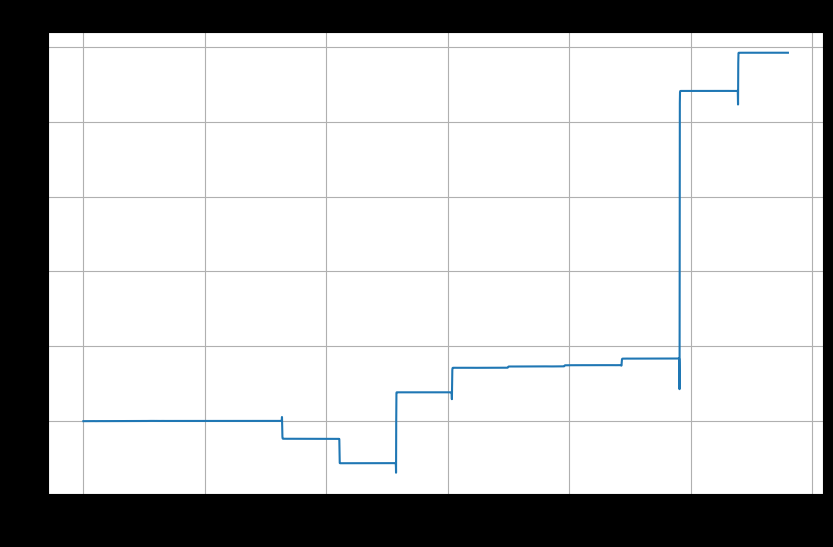

In [148]:
angular_momentum = np.zeros(len(t))
for i in range(len(t)):
    angular_momentum[i] = calculate_angular_momentum(y[i], p_he['m'])

# Plot angular momentum vs time
plt.figure(figsize=(10, 6))
plt.style.use('default')
plt.plot(t, angular_momentum)
plt.xlabel('Time')
plt.ylabel('Total Angular Momentum')
plt.title('Conservation of Angular Momentum')
plt.grid(True)
plt.show()

#### Part 3.2

In [149]:
dt = 0.001
t_span = [0, 17]
y0 = np.array([0, 0, 2.5, 0, 1, 0, 0, 0, 0, 0.4, 0, -1])  # x0, y0, x1, y1, x2, y2, vx0, vy0, vx1, vy1, vx2, vy2
p_he = { 'm': np.array([2, 1, 1]), 'dimensions': 2, 'fix_first': True }

t, y = solve_ode(n_body, t_span, y0, RK45, p_he, first_step=dt, tol=1e-6, h_max=0.1, h_min=1e-6)

anim = show_anim(t, y)
HTML(anim.to_html5_video())

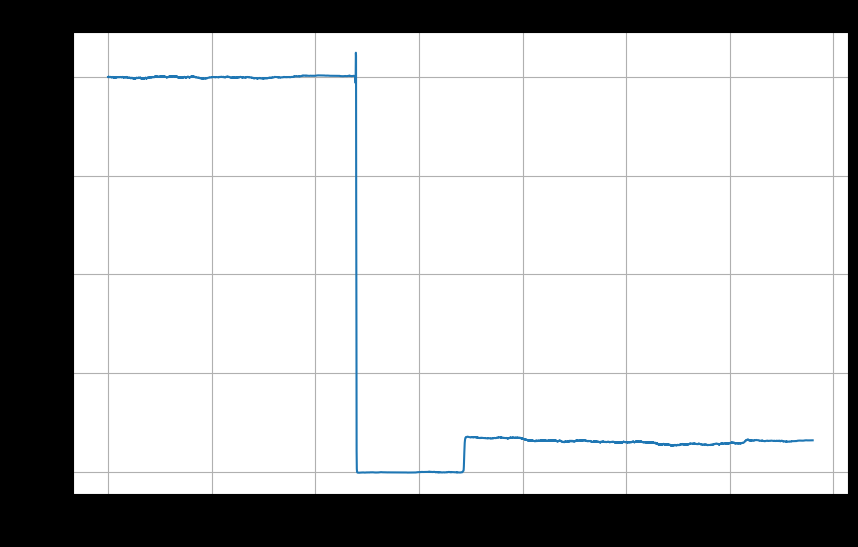

In [150]:
# Plot angular momentum vs time
angular_momentum = np.zeros(len(t))
for i in range(len(t)):
    angular_momentum[i] = calculate_angular_momentum(y[i], p_he['m'])

plt.figure(figsize=(10, 6))
plt.style.use('default')
# plt.ylim(-0.00000000001, 0.00000000001)  # Set y-axis range
plt.plot(t, angular_momentum)
plt.xlabel('Time')
plt.ylabel('Total Angular Momentum')
plt.title('Conservation of Angular Momentum')
plt.grid(True)
plt.show()

#### Part 4

In [151]:
dt = 0.001
t_span = [0, 20]
y0 = np.array([0, 0, 2, 0, -1, 0, 0, 0, 0.62, 0, 0, -1])  # x0, y0, x1, y1, x2, y2, vx0, vy0, vx1, vy1, vx2, vy2
p_he = { 'm': np.array([2, 1, 1]), 'dimensions': 2, 'fix_first': True }

t, y = solve_ode(n_body, t_span, y0, EulerRichardson, p_he, first_step=dt, tol=1e-8, h_max=0.05, h_min=1e-4)

anim = show_anim(t, y)
HTML(anim.to_html5_video())

In [152]:
def find_ionization_time(t, y, ionization_radius=6.0):
    """
    Detect ionization events in the system.

    Parameters:
    t: time array
    y: state vector array
    ionization_distance: distance at which ionization occurs

    Returns:
    ionization_times: array of times at which ionization occurs
    """
    for i in range(len(t)):
        # Calculate distances from nucleus for electrons 1 and 2
        e1 = np.sqrt(y[i, 2]**2 + y[i, 3]**2)
        e2 = np.sqrt(y[i, 4]**2 + y[i, 5]**2)

        # Return the time when either electron is beyond the ionization distance
        if e1 > ionization_radius or e2 > ionization_radius:
            return t[i]

    return t[-1]  # Return the last time if no ionization occurs

In [153]:
# Create an array of vx1 values to test between 0.6 and 1.3 at 0.02 intervals
vx1_values = np.linspace(0.6, 1.3, 36)
# print(vx1_values)

# Array to store ionization times
ionization_times = []

for vx1 in vx1_values:
    # Initial conditions with variable vx1
    dt = 0.1
    t_span = [0, 25]
    y0 = np.array([0, 0, 2, 0, -1, 0, 0, 0, vx1, 0, 0, -1])  # x0, y0, x1, y1, x2, y2, vx0, vy0, vx1, vy1, vx2, vy2
    p_he = { 'm': np.array([2, 1, 1]), 'dimensions': 2, 'fix_first': True }

    t, y = solve_ode(n_body, t_span, y0, EulerRichardson, p_he, first_step=dt, tol=1e-6, h_max=0.1, h_min=1e-6)

    # Store ionization time for this vx1 value
    result = find_ionization_time(t, y)
    ionization_times.append(result)

# Convert to numpy array
ionization_times = np.array(ionization_times)

print(ionization_times)

[ 7.5  7.7 11.3  8.3 10.2  9.8 10.  10.5 11.8 12.8 13.2 18.4 16.1 17.4
 19.7 24.3 25.  10.4  8.6  7.7  7.1  6.6  6.2  5.9  5.6  5.4  5.2  5.
  4.8  4.7  4.5  4.4  4.3  4.1  4.   3.9]


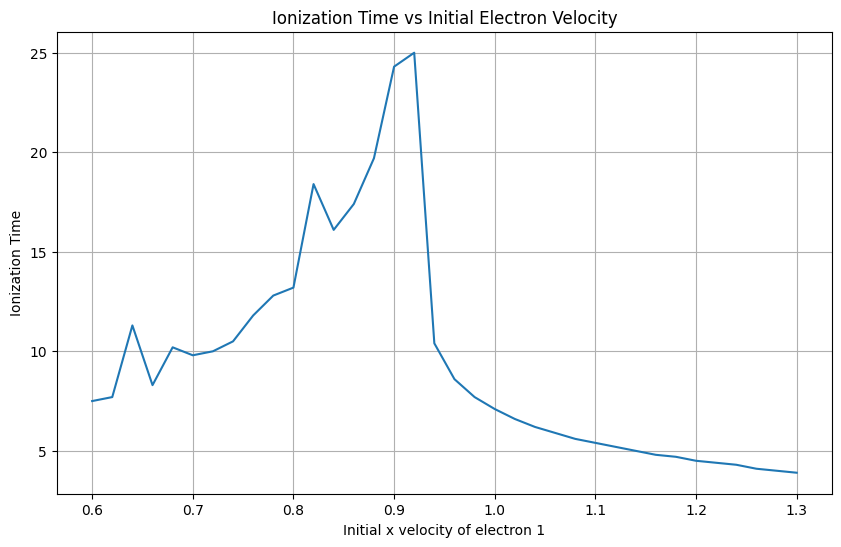

In [157]:
plt.figure(figsize=(10, 6))
plt.style.use('default')
plt.plot(vx1_values, ionization_times)
plt.xlabel('Initial x velocity of electron 1')
plt.ylabel('Ionization Time')
plt.title('Ionization Time vs Initial Electron Velocity')
plt.grid(True)
plt.show()

In [155]:
dt = 0.001
t_span = [0, 20]
y0 = np.array([0, 0, 2, 0, -1, 0, 0, 0, 0.62, 0, 0, -1])  # x0, y0, x1, y1, x2, y2, vx0, vy0, vx1, vy1, vx2, vy2
p_he = { 'm': np.array([2, 1, 1]), 'dimensions': 2, 'fix_first': True }

t, y = solve_ode(n_body, t_span, y0, EulerRichardson, p_he, first_step=dt, tol=1e-8, h_max=0.05, h_min=1e-4)

anim = show_anim(t, y)
HTML(anim.to_html5_video())

# Analysis

# Interpretation